In [29]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [30]:
train_dir = "Dataset/DatasetsnewtpIA/train"
val_dir = "Dataset/DatasetsnewtpIA/val"
all_data = "Dataset/DatasetsnewtpIA/all_data"


# Load the dataset with a validation split
batch_size = 32
img_height = 128
img_width = 128
validation_split = 0.2

In [31]:
# Training dataset
train_dataset = image_dataset_from_directory(
    all_data,
    validation_split=validation_split,
    subset="training",
    seed=123,  # Ensures consistent splitting
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Validation dataset
val_dataset = image_dataset_from_directory(
    all_data,
    validation_split=validation_split,
    subset="validation",
    seed=123,  # Same seed to ensure the split matches
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7173 files belonging to 2 classes.
Using 5739 files for training.
Found 7173 files belonging to 2 classes.
Using 1434 files for validation.


In [32]:
class_names = train_dataset.class_names
print("Class names:", class_names)

for image_batch, labels_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

Class names: ['NORMAL', 'PNEUMONIA']
Image batch shape: (32, 128, 128, 3)
Labels batch shape: (32,)


In [33]:
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
num_classes = len(class_names)

model = Sequential([
    # Example input layer (assuming 128x128, 3 channels)
    layers.Conv2D(16, (3,3), activation='relu', padding='same', 
                  input_shape=(128, 128, 3)),
    layers.Dropout(0.2),  # 20% dropout after first Conv layer
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.Dropout(0.2),  # 20% dropout after second Conv layer
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Dropout(0.2),  # 20% dropout after third Conv layer
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # 30% dropout in Dense layer
    
    # For binary classification:
    layers.Dense(1, activation='sigmoid')
])

In [36]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [38]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU is available: {gpus[0].name}")
else:
    print("No GPU detected. Training will use the CPU.")

GPU is available: /physical_device:GPU:0


In [39]:
from tensorflow.keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping_cb = EarlyStopping(
    monitor='val_loss',      # what to monitor (val_loss is common)
    patience=5,             # how many epochs with no improvement before stopping
    restore_best_weights=True
)

In [40]:
epochs=50
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=[early_stopping_cb]
)

Epoch 1/50
180/180 [==============================] - 37s 187ms/step - loss: 0.3824 - accuracy: 0.8210 - val_loss: 0.2205 - val_accuracy: 0.9484
Epoch 2/50
180/180 [==============================] - 8s 43ms/step - loss: 0.1653 - accuracy: 0.9347 - val_loss: 0.2434 - val_accuracy: 0.9386
Epoch 3/50
180/180 [==============================] - 8s 45ms/step - loss: 0.1281 - accuracy: 0.9542 - val_loss: 0.1343 - val_accuracy: 0.9616
Epoch 4/50
180/180 [==============================] - 8s 44ms/step - loss: 0.0970 - accuracy: 0.9627 - val_loss: 0.0991 - val_accuracy: 0.9756
Epoch 5/50
180/180 [==============================] - 8s 44ms/step - loss: 0.0852 - accuracy: 0.9685 - val_loss: 0.0897 - val_accuracy: 0.9770
Epoch 6/50
180/180 [==============================] - 8s 47ms/step - loss: 0.0664 - accuracy: 0.9751 - val_loss: 0.0772 - val_accuracy: 0.9756
Epoch 7/50
180/180 [==============================] - 8s 46ms/step - loss: 0.0643 - accuracy: 0.9772 - val_loss: 0.0767 - val_accuracy: 0.97

In [41]:
model.save("my_model-v4-bestOne.h5")

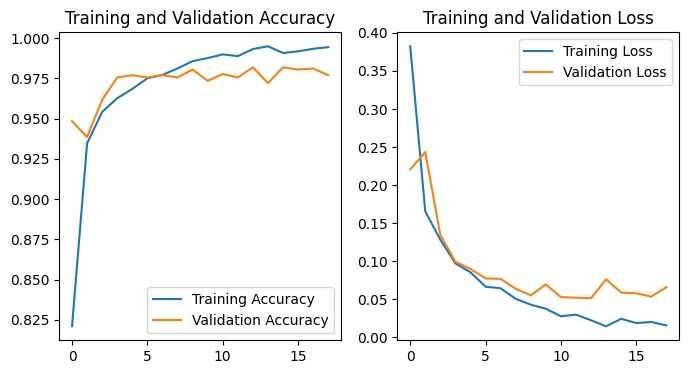

In [42]:
# Extract metrics from history
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [43]:
import tensorflow as tf

test_dir = "Dataset/DatasetsnewtpIA/test"  # Replace with the actual path to your test folder
img_height = 128
img_width = 128
batch_size = 32

# Load the test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Don't shuffle, so you can analyze predictions later
)

Found 16 files belonging to 2 classes.


In [60]:
# Load your trained model
model = tf.keras.models.load_model("my_model-v4-bestOne.h5")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 [==============================] - 0s 292ms/step - loss: 33.0534 - accuracy: 0.8750
Test Loss: 33.05336380004883
Test Accuracy: 0.875


In [71]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

def detect_using_cnn(image_path: str) -> bool:
    # 1) Load the model
    model = tf.keras.models.load_model("my_model-v4-bestOne.h5")

    # 2) Define image path and target size
    img_height, img_width = 128, 128

    # 3) Preprocess the image
    test_img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(test_img)
    img_array = np.expand_dims(img_array, axis=0)


    # 4) scale pixel values to [0,1]
    img_array = img_array / 255.0

    predictions = model.predict(img_array)
    print("Raw output:", predictions)

    # Binary classification w/ sigmoid output
    # True -> Class (1) (PNEUMONIA)
    # False -> Class 0 (NORMAL)
    return True if predictions[0][0] > 0.5 else False

In [72]:
img_path = "sick.jpeg"

if detect_using_cnn(img_path):
    print("Prediction: Class 1 (PNEUMONIA)")
else:
    print("Prediction: Class 0 (NORMAL)")


1/1 [==============================] - 0s 121ms/step
Raw output: [[0.01359105]]
Prediction: Class 0 (NORMAL)


Data Augmentation

In [23]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your original minority-class images (normal)
normal_images_dir = "Dataset/DatasetsnewtpIA/all_data/NORMAL"          # e.g., contains 1,500 images
augmented_normal_dir = "Dataset/DatasetsnewtpIA/normal_aug"   # folder where augmented images will be saved

# Create the folder if it doesn't exist
os.makedirs(augmented_normal_dir, exist_ok=True)


In [24]:
# Data generator with chosen augmentations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [25]:
# flow_from_directory will read images from `normal_images_dir` 
# (so put them under normal_images_dir/SomeClass, or just normal_images_dir if each image is a separate file).
generator = datagen.flow_from_directory(
    directory=normal_images_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,    # We don't need labels here
    shuffle=False,
    save_to_dir=augmented_normal_dir,
    save_prefix="normal_aug",
    save_format="jpg"   # or png
)

Found 1349 images belonging to 1 classes.


In [26]:
# Decide how many augmented images you want to create
num_augmented_images = 2000  # for example

# Actually generate and save images
# Each call to next(generator) produces one batch of ~32 images
batches = num_augmented_images // 32
for i in range(batches):
    generator.next()  # This will save augmented images to 'augmented_normal_dir'

print("Augmentation done. Check the folder:", augmented_normal_dir)


Augmentation done. Check the folder: Dataset/DatasetsnewtpIA/normal_aug
